# Model SBC Report

In [1]:
import logging
import warnings
from pathlib import Path
from pprint import pprint
from time import time

import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg

from src.analysis import pymc3_analysis as pmanal
from src.analysis import sbc_analysis as sbcanal
from src.exceptions import CacheDoesNotExistError
from src.loggers import set_console_handler_level
from src.managers.model_cache_managers import Pymc3ModelCacheManager
from src.modeling import simulation_based_calibration_helpers as sbc
from src.project_enums import ModelFitMethod

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

set_console_handler_level(logging.WARNING)
pymc3_cache_dir = Path("..", "models", "modeling_cache", "pymc3_model_cache")

Parameters for papermill:

- `MODEL_NAME`: unique, identifiable name of the model
- `SBC_RESULTS_DIR`: directory containing results of many rounds of SBC
- `SBC_COLLATED_RESULTS`: path to collated simulation posteriors
- `SBC_UNIFORMITY_RESULTS`: path to results of the uniformity test
- `NUM_SIMULATIONS`: the number of simiulations; will be used to check that all results are found
- `CONFIG_PATH`: path to the model configuration file
- `FIT_METHOD`: model fitting method used for this SBC

## Setup

### Papermill parameters

In [3]:
MODEL_NAME = ""
SBC_RESULTS_DIR = ""
SBC_COLLATED_RESULTS = ""
SBC_UNIFORMITY_RESULTS = ""
NUM_SIMULATIONS = -1
CONFIG_PATH = ""
FIT_METHOD_STR = ""

In [4]:
# Parameters
MODEL_NAME = "simple-default"
SBC_RESULTS_DIR = "/n/scratch3/users/j/jc604/speclet-sbc/simple-default_ADVI"
SBC_COLLATED_RESULTS = (
    "cache/sbc-cache/simple-default_ADVI_collated-posterior-summaries.pkl"
)
SBC_UNIFORMITY_RESULTS = (
    "cache/sbc-cache/simple-default_ADVI_uniformity-test-results.pkl"
)
NUM_SIMULATIONS = 1000
CONFIG_PATH = "models/model-configs.yaml"
FIT_METHOD_STR = "ADVI"

### Prepare and validate papermill parameters

Check values passed as the directory with results of the rounds of SBC.

In [5]:
path_addition = "../.."

sbc_results_dir = Path(path_addition, SBC_RESULTS_DIR)
assert sbc_results_dir.is_dir()
assert sbc_results_dir.exists()

sbc_collated_results_path = Path(path_addition, SBC_COLLATED_RESULTS)
assert sbc_collated_results_path.is_file()
assert sbc_collated_results_path.exists()

sbc_uniformity_results_path = Path(path_addition, SBC_UNIFORMITY_RESULTS)
assert sbc_uniformity_results_path.is_file()
assert sbc_uniformity_results_path.exists()

Confirm that there is a positive number of simulations.

In [6]:
assert NUM_SIMULATIONS > 0

In [7]:
FIT_METHOD = ModelFitMethod(FIT_METHOD_STR)

## Read in all results

In [8]:
# Posterior summaries dataframe.
simulation_posteriors_df = pd.read_pickle(sbc_collated_results_path)
simulation_posteriors_df.head()

,,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,true_value,simulation_id,within_hdi
parameter,parameter_name,,,,,,,,,,,,
a,a,2.344,0.147,2.131,2.581,0.005,0.003,973.0,880.0,NaN,2.364929,sim_id_0000,True
σ,σ,3.513,0.144,3.293,3.744,0.005,0.003,972.0,1026.0,NaN,3.407129,sim_id_0000,True
a,a,8.731,0.133,8.529,8.945,0.004,0.003,972.0,1026.0,NaN,8.820262,sim_id_0001,True
σ,σ,1.977,0.051,1.904,2.060,0.002,0.001,973.0,880.0,NaN,2.000786,sim_id_0001,True
a,a,2.216,0.172,1.954,2.493,0.006,0.004,972.0,1026.0,NaN,2.423401,sim_id_0002,True


In [9]:
# Uniformity test results dataframe.
sbc_uniformity_test = pd.read_pickle(sbc_uniformity_results_path)
var_names = sbc_uniformity_test.parameter.tolist()
parameter_names = [x.split("[")[0] for x in var_names]
sbc_uniformity_test["parameter_name"] = parameter_names
sbc_uniformity_test.head()

,parameter,rank_stat,parameter_name
0,a,23,a
1,σ,34,σ
0,a,73,a
1,σ,33,σ
0,a,39,a


## Analysis

In [10]:
sbc_analyzer = sbcanal.SBCAnalysis(
    root_dir=sbc_results_dir,
    pattern="perm",
    n_simulations=NUM_SIMULATIONS,
    simulation_posteriors=simulation_posteriors_df,
    uniformity_test_results=sbc_uniformity_test,
)

### ADVI approximation histories

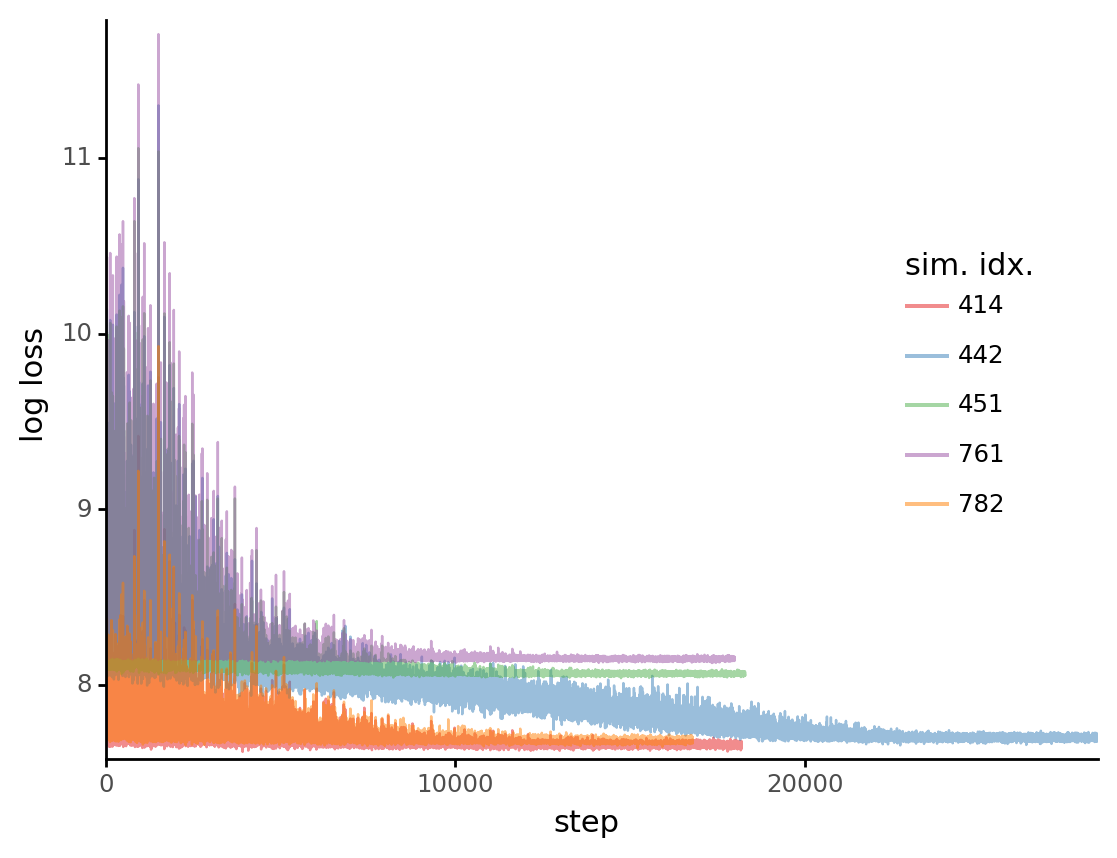

In [11]:
if FIT_METHOD is ModelFitMethod.ADVI:
    advi_histories: list[np.ndarray] = []
    example_result_dirs = sbc_analyzer.random_simulation_directories(5)
    for dir in example_result_dirs:
        cache_manager = Pymc3ModelCacheManager(name=MODEL_NAME, root_cache_dir=dir)
        if cache_manager.advi_cache_exists():
            _, advi_approx = cache_manager.get_advi_cache()
            advi_histories.append(advi_approx.hist)
        else:
            raise CacheDoesNotExistError("Missing SBC results.")

    def make_hist_df(advi_history: np.ndarray, sim_idx: int) -> pd.DataFrame:
        df = pd.DataFrame({"sim_idx": sim_idx, "loss": advi_history.flatten()})
        df["step"] = np.arange(df.shape[0])
        return df

    sample_advi_indices = [d.name.replace("sbc-perm", "") for d in example_result_dirs]
    sampled_advi_histories = pd.concat(
        [make_hist_df(ah, i) for ah, i in zip(advi_histories, sample_advi_indices)]
    ).reset_index(drop=True)

    (
        gg.ggplot(
            sampled_advi_histories,
            gg.aes(x="step", y="np.log(loss)", color="factor(sim_idx)"),
        )
        + gg.geom_line(alpha=0.5)
        + gg.scale_color_brewer(type="qual", palette="Set1")
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_continuous(expand=(0.01, 0, 0.02, 0))
        + gg.theme(legend_position=(0.8, 0.5))
        + gg.labs(y="log loss", color="sim. idx.")
    ).draw()
    plt.show()

### MCMC diagnostics

In [12]:
if FIT_METHOD is ModelFitMethod.MCMC:
    pprint(sbc_analyzer.mcmc_diagnostics())
    print("=" * 60)

    for perm_dir in sbc_analyzer.random_simulation_directories(5):
        print(perm_dir.name)
        print("-" * 30)
        sbc_fm = sbc.SBCFileManager(perm_dir)
        if sbc_fm.all_data_exists():
            sbc_res = sbc_fm.get_sbc_results()
            _ = pmanal.describe_mcmc(sbc_res.inference_obj)
        else:
            raise CacheDoesNotExistError("Missing SBC results.")

### Estimate accuracy

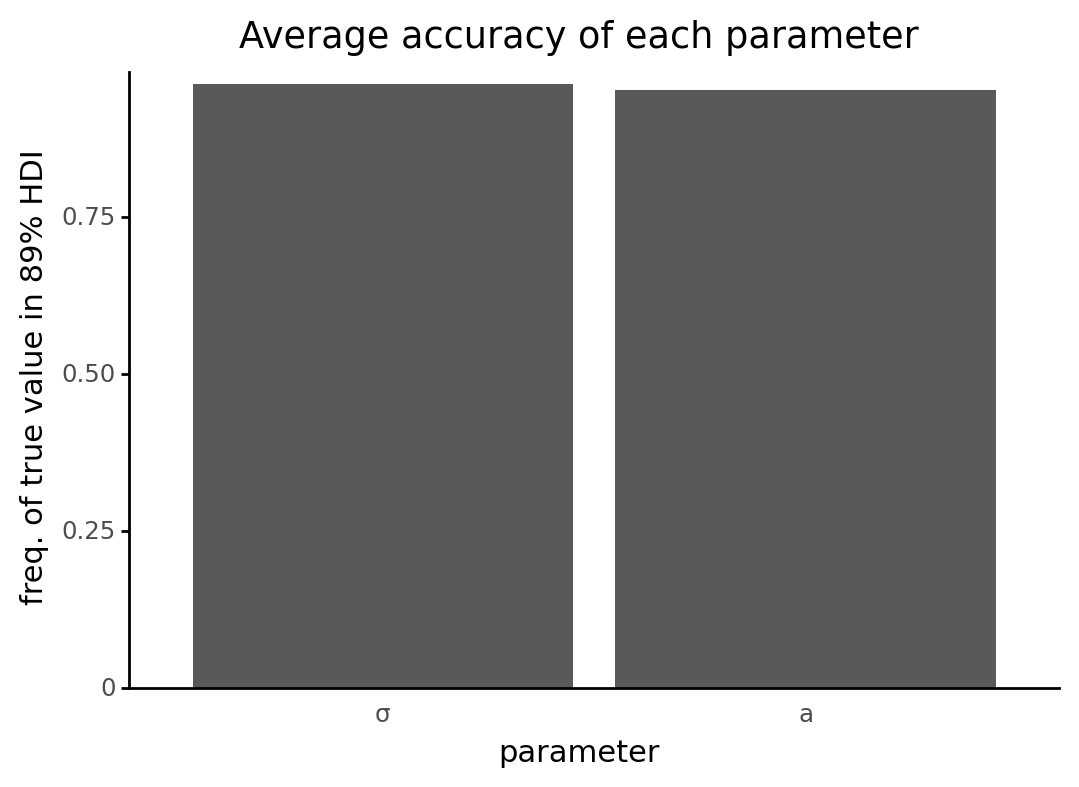

<ggplot: (2952269975793)>

In [13]:
accuracy_per_parameter = sbc_analyzer.run_posterior_accuracy_test()

accuracy_per_parameter["parameter_name"] = pd.Categorical(
    accuracy_per_parameter["parameter_name"],
    categories=accuracy_per_parameter["parameter_name"].values,
)

(
    gg.ggplot(accuracy_per_parameter, gg.aes(x="parameter_name", y="within_hdi"))
    + gg.geom_col()
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(
        x="parameter",
        y="freq. of true value in 89% HDI",
        title="Average accuracy of each parameter",
    )
    + gg.theme(axis_ticks_major_x=gg.element_blank(), figure_size=(6, 4))
)

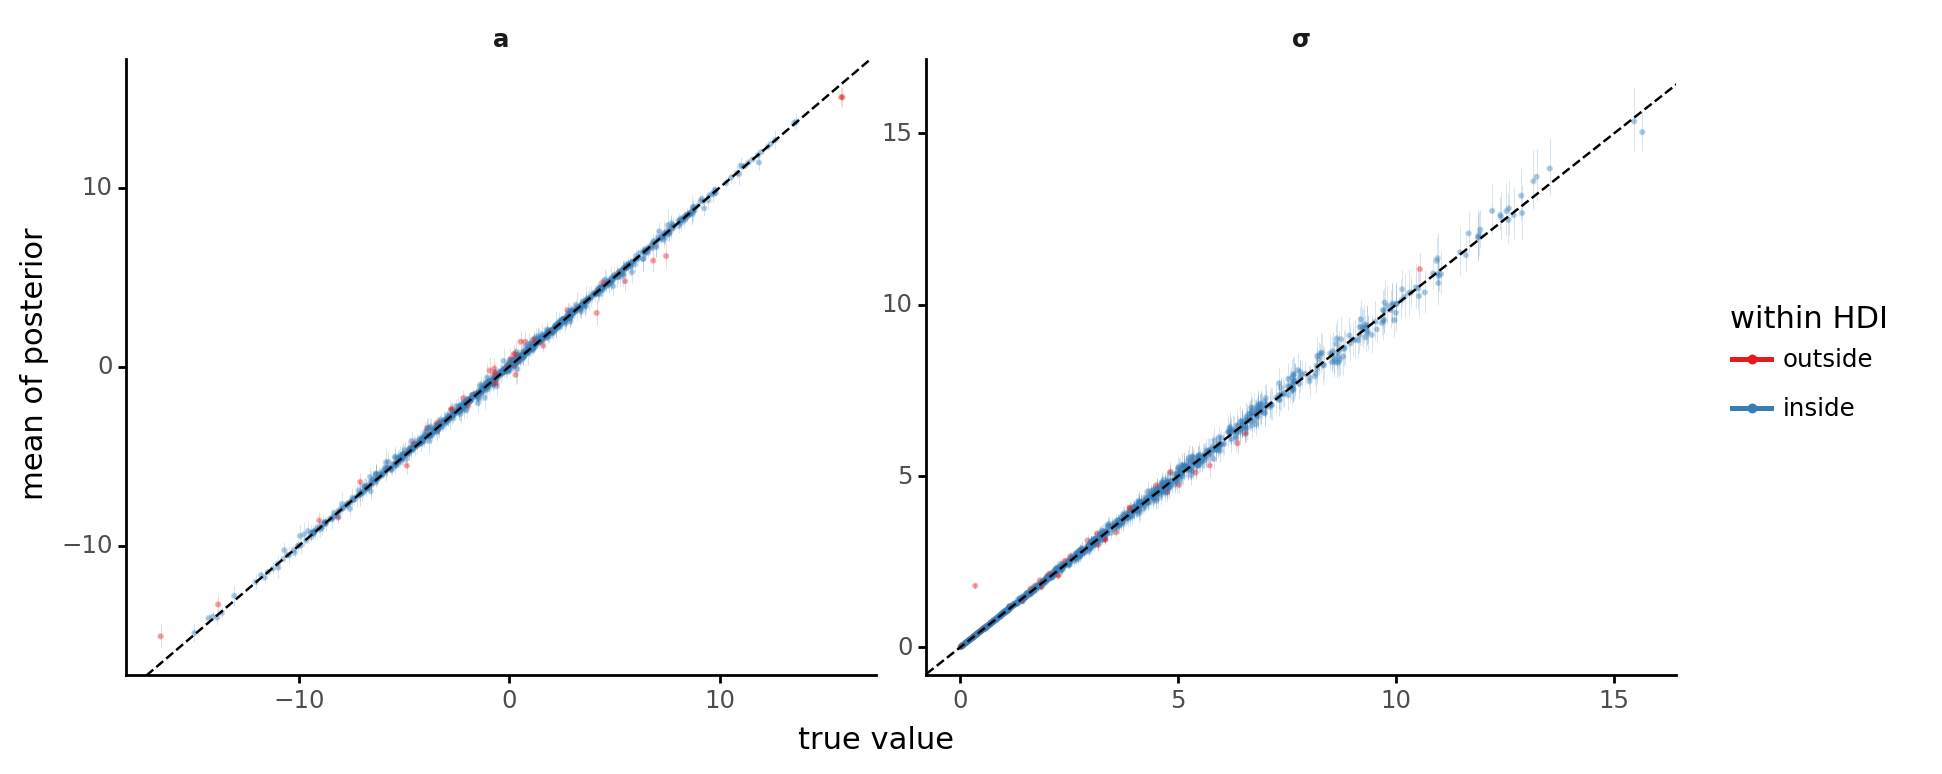

<ggplot: (2952269891850)>

In [14]:
hdi_low, hdi_high = pmanal.get_hdi_colnames_from_az_summary(simulation_posteriors_df)


def filter_uninsteresting_parameters(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.reset_index(drop=False)
        .query("parameter_name != 'μ'")
        .filter_string("parameter_name", search_string="offset", complement=True)
    )


plot_df = filter_uninsteresting_parameters(simulation_posteriors_df)
n_params = plot_df.parameter_name.nunique()
plot_height = (1 + n_params // 4) * 4

(
    gg.ggplot(plot_df, gg.aes(x="true_value", y="mean", color="within_hdi"))
    + gg.facet_wrap("~ parameter_name", ncol=3, scales="free")
    + gg.geom_linerange(gg.aes(ymin=hdi_low, ymax=hdi_high), alpha=0.2, size=0.2)
    + gg.geom_point(size=0.3, alpha=0.3)
    + gg.geom_abline(slope=1, intercept=0, linetype="--")
    + gg.scale_color_brewer(
        type="qual",
        palette="Set1",
        labels=("outside", "inside"),
        guide=gg.guide_legend(
            title="within HDI",
            override_aes={"alpha": 1, "size": 1},
        ),
    )
    + gg.theme(
        figure_size=(10, plot_height),
        strip_background=gg.element_blank(),
        strip_text=gg.element_text(face="bold"),
        panel_spacing=0.25,
    )
    + gg.labs(
        x="true value",
        y="mean of posterior",
    )
)

### SBC Uniformity Test

In [15]:
var_names_to_plot = (
    sbc_uniformity_test[["parameter", "parameter_name"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .sort_values(["parameter_name", "parameter"])
    .groupby("parameter_name")
    .head(3)
    .reset_index(drop=True)
    .parameter.tolist()
)

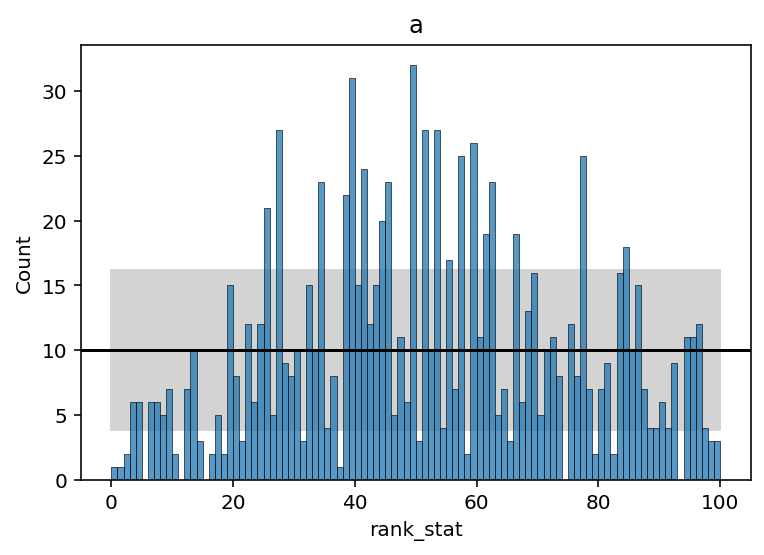

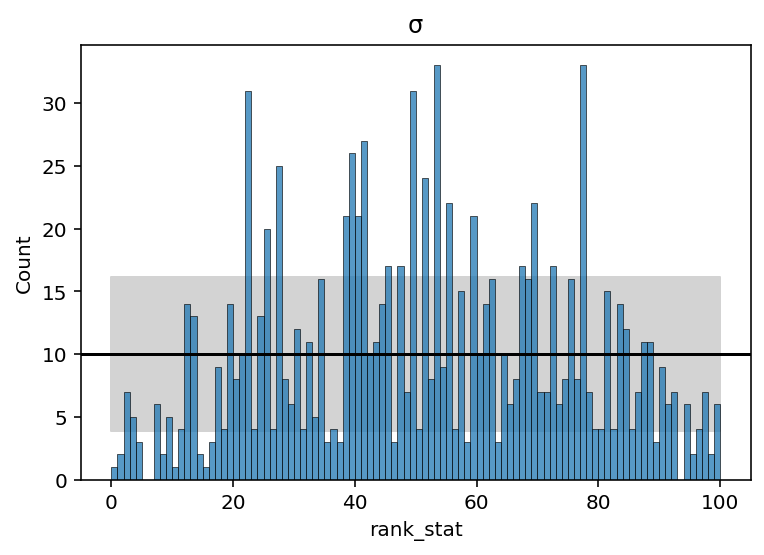

In [16]:
for v in var_names_to_plot:
    ax = sbc_analyzer.plot_uniformity(
        sbc_uniformity_test.query(f"parameter == '{v}'").reset_index(drop=True)
    )
    ax.set_title(v)
    plt.show()

---

In [17]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.09 minutes


In [18]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-08-25

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-238.o2.rc.hms.harvard.edu

Git branch: fix-theano-lock

numpy     : 1.21.2
pandas    : 1.3.2
janitor   : 0.21.0
matplotlib: 3.4.3
plotnine  : 0.8.0
logging   : 0.5.1.2

